## Expert Knowledge Worker

### A question answering agent that is an expert knowledge worker
### To be used by employees of Insurellm, an Insurance Tech company
### The agent needs to be accurate and the solution should be low cost.

This project will use RAG (Retrieval Augmented Generation) to ensure our question/answering assistant has high accuracy.

This first implementation will use a simple, brute-force type of RAG..

In [1]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [2]:
# imports for langchain, plotly and Chroma

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.embeddings import HuggingFaceEmbeddings

In [3]:
# price is a factor for us, so we're going to use a free model

MODEL = "llama3.2"
db_name = "vector_db"

In [4]:
# Read in documents using LangChain's loaders
# Take everything in all the sub-folders of our knowledgebase

folders = glob.glob("knowledge-base/*")

def add_metadata(doc, doc_type):
    doc.metadata["doc_type"] = doc_type
    return doc

text_loader_kwargs = {'encoding': 'utf-8'}
# If that doesn't work, some Windows users might need to uncomment the next line instead
# text_loader_kwargs={'autodetect_encoding': True}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    documents.extend([add_metadata(doc, doc_type) for doc in folder_docs])

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

print(f"Total number of chunks: {len(chunks)}")
print(f"Document types found: {set(doc.metadata['doc_type'] for doc in documents)}")

Created a chunk of size 1088, which is longer than the specified 1000


Total number of chunks: 123
Document types found: {'products', 'company', 'employees', 'contracts'}


## A sidenote on Embeddings, and "Auto-Encoding LLMs"

We will be mapping each chunk of text into a Vector that represents the meaning of the text, known as an embedding.

Ollama offers a model to do this, which we will use by calling their API with some LangChain code.

This model is an example of an "Auto-Encoding LLM" which generates an output given a complete input.
It's different to all the other LLMs, which are known as "Auto-Regressive LLMs", and generate future tokens based only on past context.

Another example of an Auto-Encoding LLMs is BERT from Google. In addition to embedding, Auto-encoding LLMs are often used for classification.


In [5]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk
# Chroma is a popular open source Vector Database based on SQLLite

# embeddings = OpenAIEmbeddings()

# If you would rather use the free Vector Embeddings from HuggingFace sentence-transformers
# Then replace embeddings = OpenAIEmbeddings()
# with:
# from langchain.embeddings import HuggingFaceEmbeddings
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
!pip install -U langchain-huggingface
import os
from langchain_huggingface import HuggingFaceEmbeddings
# Optional: silence symlink warning
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# Use free HuggingFace embeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
# Delete if already exists

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

# Create vectorstore

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 123 documents


In [6]:
# Let's investigate the vectors

collection = vectorstore._collection
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 123 vectors with 384 dimensions in the vector store


## Visualizing the Vector Store

Let's take a minute to look at the documents and their embedding vectors to see what's going on.

In [8]:
# Prework

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['doc_type'] for metadata in metadatas]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]

C:\Users\ARYAN\anaconda3\envs\llms\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\ARYAN\anaconda3\envs\llms\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ARYAN\anaconda3\envs\llms\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\ARYAN\anaconda3\envs\llms\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^

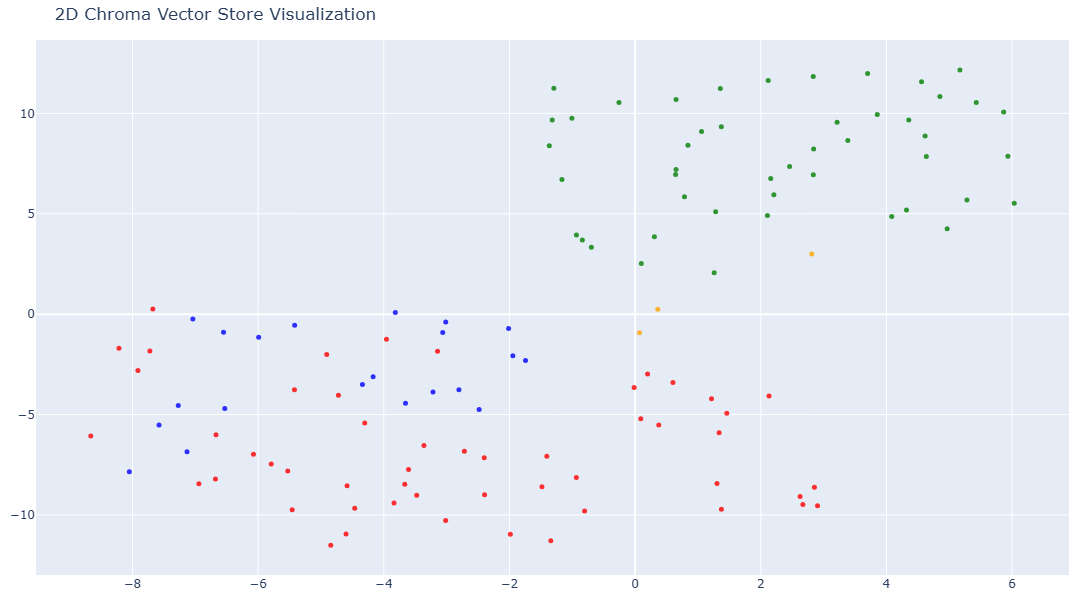

In [9]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

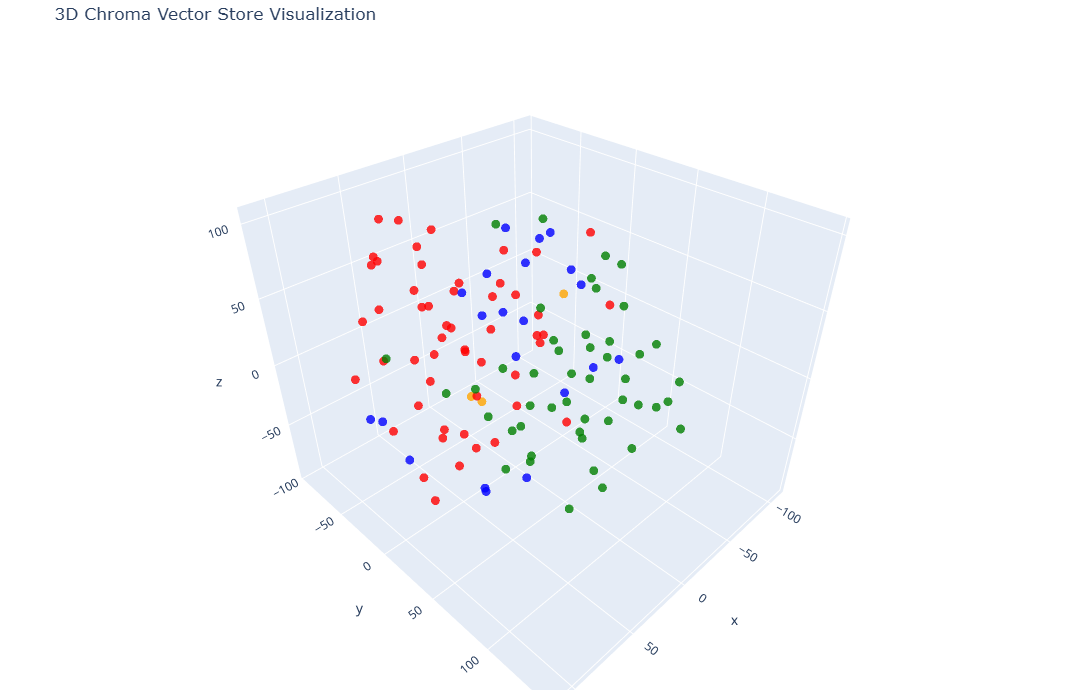

In [10]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

## Time to use LangChain to bring it all together

In [12]:
# create a new Chat with OpenAI
# llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# Alternative - if you'd like to use OpenAI, uncomment the line above. 
llm = ChatOpenAI(temperature=0.7, model_name='llama3.2', base_url='http://localhost:11434/v1', api_key='ollama')

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = vectorstore.as_retriever()

# putting it together: set up the conversation chain with the llama3.2, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [13]:
# Let's try a simple question

query = "Please explain what Insurellm is in a couple of sentences"
result = conversation_chain.invoke({"question": query})
print(result["answer"])

I don't know the specific details about Insurellm beyond what's provided in the context you shared. However, based on the information I do have, it appears to be an insurance tech startup that offers various software products for different sectors of the insurance industry, including auto, home, and reinsurance.


In [14]:
# set up a new conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# putting it together: set up the conversation chain with the llama3.2 LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

## Now we will bring this up in Gradio using the Chat interface -

A quick and easy way to prototype a chat with an LLM

In [15]:
# Wrapping that in a function

def chat(question, history):
    result = conversation_chain.invoke({"question": question})
    return result["answer"]

In [16]:
# And in Gradio:

view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


In [18]:
# Let's investigate what gets sent behind the scenes

from langchain_core.callbacks import StdOutCallbackHandler

llm = ChatOpenAI(temperature=0.7, model_name='llama3.2', base_url='http://localhost:11434/v1', api_key='ollama')

memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

retriever = vectorstore.as_retriever()

conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory, callbacks=[StdOutCallbackHandler()])

query = "Who received the prestigious IIOTY award in 2023?"
result = conversation_chain.invoke({"question": query})
answer = result["answer"]
print("\nAnswer:", answer)



> Entering new ConversationalRetrievalChain chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
## Annual Performance History
- **2020:**  
  - Completed onboarding successfully.  
  - Met expectations in delivering project milestones.  
  - Received positive feedback from the team leads.

- **2021:**  
  - Achieved a 95% success rate in project delivery timelines.  
  - Awarded "Rising Star" at the annual company gala for outstanding contributions.  

- **2022:**  
  - Exceeded goals by optimizing existing backend code, improving system performance by 25%.  
  - Conducted training sessions for junior developers, fostering knowledge sharing.  

- **2023:**  
  - Led a major overhaul of the API internal architecture, enhancing security proto

In [19]:
# create a new Chat with llama3.2
llm = ChatOpenAI(temperature=0.7, model_name='llama3.2', base_url='http://localhost:11434/v1', api_key='ollama')

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG; k is how many chunks to use
retriever = vectorstore.as_retriever(search_kwargs={"k": 25})

# putting it together: set up the conversation chain with the llama3.2 LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [20]:
def chat(question, history):
    result = conversation_chain.invoke({"question": question})
    return result["answer"]

In [21]:
view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


# Exercises

Try applying this to your own folder of data, so that you create a personal knowledge worker, an expert on your own information!